# Stöðuskýrsla - Vélræn listaverk

### Brynja, Egill og Valgerður

## Inngangur

Í þessari stöðuskýrslu skoðum við gögnin sem við ætlum að vinna með í verkefninu, búum til einfalt samanburðarmódel sem er flokkari sem flokkar myndir í tvo flokka og tölum um næstu skref.

Verkefnið snýst um að þróa GAN algóritma þannig að flokkari geri ekki greinarmun á milli alvöru listaverks og hinu vélræna listaverki sem algóritminn spýtir út úr sér. 
Til að byrja með notum við gögn úr Kaggle keppninni *I'm Something of a Painter Myself* en gagnasettið þar inniheldur fjölda málverka eftir franska listamanninn Claude Monet ásamt venjulegum ljósmyndum af hinum ýmsu hlutum. Gagnasettið inniheldur fjórar möppur: $\tt monet\_tfrec$, $\tt photo\_tfrec$, $\tt monet\_jpg$ og $\tt photo\_jpg$. Möppurnar $\tt monet\_tfrec$ og $\tt monet\_jpg$ innihalda 300 málverk eftir Monet af pixlastærð 256x256, annarsvegar á TFRecord formati og hinsvegar á JPG format. Þær myndir munum við nota til þess að þjálfa módelið. Möppurnar $\tt photo\_tfrec$ og $\tt photo\_jpg$ innihalda 7038 myndir á TFRecord formati og  JPG format. Þær viljum við gera að vélrænum listaverkum í anda Monet. Við munum nota gögnin sem eru á JPG formati hér á eftir til þess að búa til flokkara sem flokkar myndir í málverk eftir Monet og ljósmyndir. 

## Gögn sótt

Við hefjumst handa við að ná í þessi tilteknu gögn og skoða þau í python. Við munum geyma gögnin á Google Drive. 

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Á Google drifinu eru þau geymd á tilteknum stað í möppunni VM og undirmöppunni monet_gogn. Við ætlum að nota JPG formatið á myndunum svo við búum til möppu sem heitir $\texttt{jpg}$. Í þessum „path“ eru gögnin geymd:

In [2]:
#Staðsetning gagnasettsins á Google drifinu
image_path = "/content/drive/MyDrive/VM/monet_gogn/jpg"

Skilgreinum nú fall $\tt loadImages\_monet$ sem les inn jpg myndirnar úr möppunni $\tt monet\_jpg$ og annað fall $\tt loadImages\_photo$ sem les inn jpg myndirnar úr möppunni $\tt photo\_jpg$:

In [3]:
import os
import numpy as np
import cv2

def loadImages_monet(path):
    image_files = sorted([os.path.join(path, 'monet_jpg', file)
                          for file in os.listdir(path + "/monet_jpg")
                          if file.endswith('.jpg')])
    return image_files

def loadImages_photo(path):
    image_files = sorted([os.path.join(path, 'photo_jpg', file)
                          for file in os.listdir(path + "/photo_jpg")
                          if file.endswith('.jpg')])
    return image_files

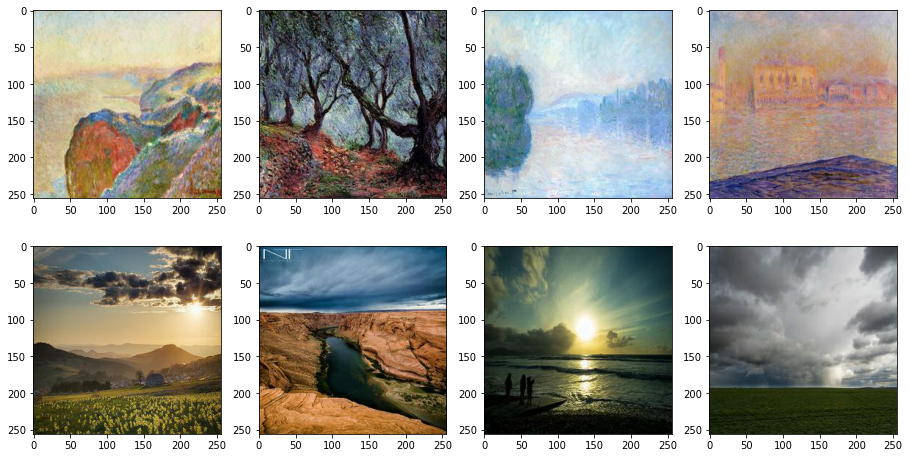

In [4]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

monet_jpg = loadImages_monet(image_path)
photo_jpg = loadImages_photo(image_path)

fig = plt.figure(figsize=(12,6))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.2, wspace=0.2)

img = [monet_jpg[0], monet_jpg[1], monet_jpg[2], monet_jpg[3],
       photo_jpg[0], photo_jpg[1], photo_jpg[2], photo_jpg[3]]

for i in range(len(img)):
    plt.subplot(2,4,(i+1))
    imgplot = plt.imshow(mpimg.imread(img[i]))

In [5]:
#Geymum myndirnar í lista
monet_jpg = loadImages_monet(image_path)
photo_jpg = loadImages_photo(image_path)

Á eftirfarandi mynd má sjá fjölda málverka eftir Monet borið saman við fjölda ljósmynda í gagnasettinu.

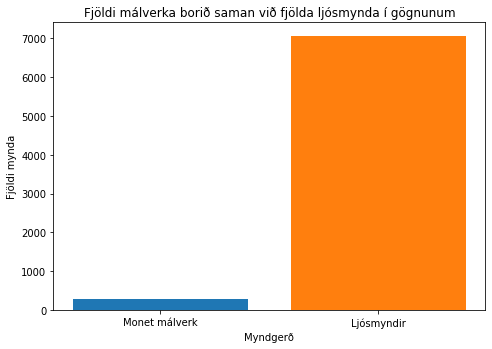

Fjöldi mynda í monet_jpg: 302
Fjöldi mynda í photo_jpg: 7047


In [6]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
data = ['Monet málverk', 'Ljósmyndir']
count = [len(monet_jpg), len(photo_jpg)]
ax.bar(data, count, color = ['#1f77b4', '#ff7f0e'])
ax.set_xlabel('Myndgerð')
ax.set_ylabel('Fjöldi mynda')
ax.set_title('Fjöldi málverka borið saman við fjölda ljósmynda í gögnunum')
plt.show()

print('Fjöldi mynda í monet_jpg:', len(monet_jpg))
print('Fjöldi mynda í photo_jpg:', len(photo_jpg)) 

Skoðum nú eina mynd úr hvorum flokk:

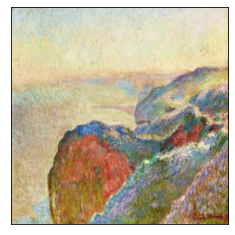

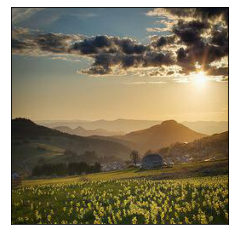

In [7]:
import matplotlib.pyplot as plt
from PIL import Image

#Fall til þess að birta eina mynd
def display1(a):
    plt.imshow(a)
    plt.xticks([]), plt.yticks([])
    plt.show()

im2 = Image.open(monet_jpg[0])
display1(im2)

im1 = Image.open(photo_jpg[0])
display1(im1)

## Flokkari búinn til

Nú skulum við búa til einfaldan flokkara sem gerir greinarmun á Monet málverkunum og ljósmyndunum. Við höfum því tvo flokka: Monet málverk og ljósmyndir.

In [8]:
path = "/content/drive/MyDrive/VM/monet_gogn/jpg"
classes = []
for d in os.listdir(path):
  if os.path.isdir(os.path.join(path, d)) and not d.startswith('.'):
    classes.append(d)
print("Fjöldi flokka: ", len(classes), "\nFlokkarnir eru", classes)

Fjöldi flokka:  2 
Flokkarnir eru ['monet_jpg', 'photo_jpg']


### Undirbúningur 

Þar sem að myndirnar í $\tt photo\_jpg$ möppunni eru miklu fleiri skulum við aðeins nota 300 myndir úr þeirri möppu svo jafnvægi sé á milli flokkanna. Skiptum gögnunum í þjálfunar- og validation gögn þar sem að 80 % gagnanna eru þjálfunargögn og 20 % validation gögn:

In [9]:
### Búa til train og val gögn
from sklearn.model_selection import train_test_split

image_directory_monet = "/content/drive/MyDrive/VM/monet_gogn/jpg/monet_jpg"
data_monet = os.listdir(image_directory_monet)
train_monet, val_monet = train_test_split(data_monet, test_size=0.2, random_state=1)

image_directory_photo = "/content/drive/MyDrive/VM/monet_gogn/jpg/photo_jpg"
data_photo = os.listdir(image_directory_photo)[:300]   #hofum bara 300 fyrstu myndirnar ur photo_jpg gagnasettinu
train_photo, val_photo = train_test_split(data_photo, test_size=0.2, random_state=1)

Á eftirfarandi mynd má sjá hlutfall þjálfunar- og validation gagna sem við mundum nota til þess að búa til flokkara:

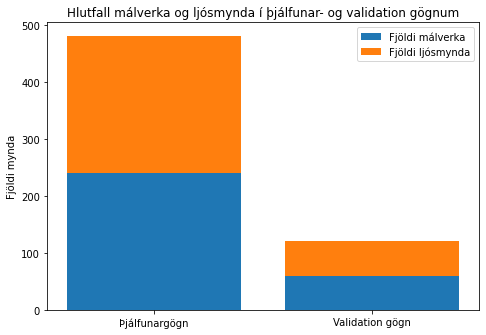

Fjöldi þjálfunargagna í Monet flokk: 241 myndir
Fjöldi þjálfunargagna í ljósmyndaflokk: 240 myndir
Fjöldi validation gagna í Monet flokk: 61 myndir
Fjöldi validation gagna í ljósmyndaflokk: 60 myndir


In [10]:
## Plotta hlutfall þjálfunar og validation gagna
monet = [len(train_monet), len(val_monet)]
photo = [len(train_photo), len(val_photo)]
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(['Þjálfunargögn','Validation gögn'], monet)
ax.bar(['Þjálfunargögn','Validation gögn'], photo, bottom = monet)
ax.set_ylabel('Fjöldi mynda')
ax.set_title('Hlutfall málverka og ljósmynda í þjálfunar- og validation gögnum')
ax.legend(labels=['Fjöldi málverka', 'Fjöldi ljósmynda'])
plt.show()

print('Fjöldi þjálfunargagna í Monet flokk:', len(train_monet), 'myndir')
print('Fjöldi þjálfunargagna í ljósmyndaflokk:', len(train_photo), 'myndir')
print('Fjöldi validation gagna í Monet flokk:', len(val_monet), 'myndir')
print('Fjöldi validation gagna í ljósmyndaflokk:', len(val_photo), 'myndir')

Búum nú til train og validation möppur inn á Google drifinu okkar:

In [11]:
#ÞENNAN KÓÐA ÞARF BARA AÐ KEYRA EINU SINNI
dirName = "/content/drive/MyDrive/VM/monet_gogn"   #yfirmappan

#Búum til train möppu
os.mkdir(dirName + "/train")
print("Directory " , dirName ,  " Created ") 

#Búum til valid möppu
os.mkdir(dirName + "/valid")
print("Directory " , dirName ,  " Created ") 

#Búum til monet möppu innan train möppu
os.mkdir(dirName + "/train/monet")
print("Directory " , dirName ,  " Created ") 

#Búum til photo möppu innan train möppu
os.mkdir(dirName + "/train/photo")
print("Directory " , dirName ,  " Created ") 

#Búum til monet möppu innan valid möppu
os.mkdir(dirName + "/valid/monet")
print("Directory " , dirName ,  " Created ") 

#Búum til photo möppu innan valid möppu
os.mkdir(dirName + "/valid/photo")
print("Directory " , dirName ,  " Created ") 

FileExistsError: ignored

Setjum viðeigandi gögn inn í þessar möppur:

In [ ]:
#ÞENNAN KÓÐA ÞARF BARA AÐ KEYRA EINU SINNI
import shutil, os

dir = "/content/drive/MyDrive/VM/monet_gogn"

os.chdir(dir + "/jpg/monet_jpg")
files = train_monet
for f in files:
    shutil.copy(f, dir + "/train/monet")

os.chdir(dir + "/jpg/monet_jpg")
files = val_monet
for f in files:
    shutil.copy(f, dir + "/valid/monet")

os.chdir(dir + "/jpg/photo_jpg")
files = train_photo
for f in files:
    shutil.copy(f, dir + "/train/photo")

os.chdir(dir + "/jpg/photo_jpg")
files = val_photo
for f in files:
    shutil.copy(f, dir + "/valid/photo")

### Földunarnet skilgreint

Við ætlum að nota földunarnet (CNN) til þess að flokka málverkin frá ljósmyndunum. Við notum $\tt ImageDataGenerator$ frá keras til þess að búa til gagnasettin og kvörðum gögnin frá $[0, 255]$ niður í $[0,1]$. 

In [13]:
#Normalisera
from tensorflow.keras.preprocessing.image import ImageDataGenerator 

dirName = "/content/drive/MyDrive/VM/monet_gogn"   #yfirmappan

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1/255)
validation_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_directory(
        dirName + "/train",  #Uppspretta þjálfunarmynda
        classes = ['photo', 'monet'], #Flokkar
        target_size=(256, 256),  #Stærð mynda
        batch_size=1, 
        class_mode='binary')

validation_generator = validation_datagen.flow_from_directory(
        dirName + "/valid",  #Uppspretta validation gagna
        classes = ['photo', 'monet'], #Flokkar
        target_size=(256, 256),    #Stærð mynda
        batch_size=1,
        class_mode='binary',
        shuffle=False)

Found 512 images belonging to 2 classes.
Found 120 images belonging to 2 classes.


Skilgreinum nú módelið okkar. Við nýtum okkur forþjálfaða tauganetið $\tt VGG16$ til þess að þjálfa flokkarann okkar. Þetta gerum við m.a. til þess að spara tíma en auk þess er gagnasettið okkar ekki mjög stórt.

In [14]:
#Notum forþjálfað net
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16

base_model = VGG16(input_shape = (256, 256, 3), # Shape of our images
include_top = False, #Leave out the last fully connected layer
weights = 'imagenet')

for layer in base_model.layers:
    layer.trainable = False

58892288/58889256 [==============================] - 0s 0us/step


Svo búum við til seinasta lagið í netinu okkar:

In [15]:
from tensorflow.keras import layers
from tensorflow.keras import Model 

x = layers.Flatten()(base_model.output)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.models.Model(base_model.input, x)

Skoðum módelið sem við höfum byggt:

In [ ]:
model.summary()

### Þjálfun

Næst skulum við þjálfa módelið. Við munum þjálfa það með „BinaryCrossentropy“ kostnaðarfalli. Við munum nota „RMSProp“ bestun (e. optimizer). „RMSProb“ er sniðugt reiknirit sem stillir „learning rate“ á sjálfvirkan hátt. Við munum svo nota nákvæmni (e. accuracy) sem „metric“.

In [16]:
model.compile(optimizer = tf.keras.optimizers.RMSprop(lr=0.0001), 
              loss = 'binary_crossentropy', 
              metrics = ['acc'])

In [18]:
history = model.fit(train_generator, validation_data = validation_generator,
                    steps_per_epoch = 100, 
                    epochs = 15)

Epoch 1/15
100/100 [==============================] - 79s 796ms/step - loss: 0.7177 - acc: 0.6900 - val_loss: 0.6629 - val_acc: 0.6583
Epoch 2/15
100/100 [==============================] - 23s 230ms/step - loss: 0.6436 - acc: 0.7000 - val_loss: 0.3700 - val_acc: 0.8417
Epoch 3/15
100/100 [==============================] - 18s 179ms/step - loss: 0.5758 - acc: 0.7800 - val_loss: 1.2568 - val_acc: 0.5333
Epoch 4/15
100/100 [==============================] - 16s 157ms/step - loss: 0.5867 - acc: 0.7300 - val_loss: 0.3474 - val_acc: 0.8500
Epoch 5/15
100/100 [==============================] - 13s 130ms/step - loss: 0.4377 - acc: 0.8100 - val_loss: 0.5083 - val_acc: 0.8333
Epoch 6/15
 41/100 [===========>..................] - ETA: 4s - loss: 0.3152 - acc: 0.8537

UnknownError: ignored

### Niðurstöður

Á eftirfarandi mynd má sjá „loss“ og „accuracy“ módelsins sem fall af „epochs“. 

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

Metum nú flokkunarnákvæmni módelsins:

In [ ]:
loss, acc = model.evaluate(validation_generator)
print("Flokkunarnákvæmnin er:", acc*100, "%" )

Á eftirfarandi mynd má sjá ROC feril flokkarans. ROC ferillinn sýnir True positive rate á móti False positive rate. Hér er AUC (area under curve) = 0.98 sem bendir til þess að flokkarinn sé ágætlega góður.  

In [ ]:
import numpy as np
from sklearn import metrics

STEP_SIZE_TEST=validation_generator.n//validation_generator.batch_size, 
validation_generator.reset(),
preds = model.predict(validation_generator,
verbose=1)

fpr, tpr, _ = metrics.roc_curve(validation_generator.classes, preds)
roc_auc = metrics.auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()

Notum nú módelið til að meta hvort að tiltekin mynd sé listaverk eftir Monet eða venjuleg ljósmynd.

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = '/content/' + fn
  img = image.load_img(path, target_size=(256, 256))
  x = image.img_to_array(img)
  plt.imshow(x/255.)
  x = np.expand_dims(x, axis=0)
  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(classes[0])
  if classes[0]<0.5:
    print(fn + " er ljósmynd")
  else:
    print(fn + " er málverk eftir Monet")

## Næstu skref

Vel tókst til við það að hlaða gögnunum inn á svæðið okkar og búa til þennan einfalda flokkara. Á næstu dögum verður unnið að gerð GAN algóritmans til þess að búa til málverk úr ljósmyndum. Þjálfa þarf "generator" tauganetið þannig að það nái að plata „discriminator“ tauganetið. Flokkarinn sem lýstur var hér að ofan verður notaður sem „discriminator“ og því þarf nú að smíða „generator“.

Þegar það hefur tekist verða nýjar leiðir til að láta tauganet breyta ljósmyndum í málverk skoðaðar. „Neural style transfer“ er sniðugt tól til að breyta venjulegum myndum í málverk í stíl einhvers annars málverks. Þá er unnið með tvær myndir: viðfangsmynd sem á að breyta, og listræna mynd  (e. style reference image) t.d. málverk eftir Monet. Útkoman er viðfangsmyndin í stíl listrænu myndarinnar. Til þess að meta niðurstöðurnar mætti nota flokkarann úr GAN algóritmanum.

Ef tími gefst verður fleiri málurum bætt við GAN algóritmann þannig að hægt verði að láta það búa til mynd í stíl annarra málara en Monet. Einnig væri gaman að prófa að blanda saman málurum þannig að mynd gæti verið að hluta til í stíl eins málara og að hluta til í stíl annars málara. Það gæti endað í einhverjum skrítnum myndum en það gæti líka orðið mjög áhugavert. Til þess að geta gert það þarf að búa til ný gagnasöfn fyrir alla þá málara sem á að herma en það gæti tekið töluverðan tíma. Einnig þarf að hafa í huga að stíll málara getur breyst í gegn um ferilinn svo til þess að hafa skýra hugmynd um hvaða stíl skal herma þarf að huga að því við gagnasöfnun.

## Samantekt

Gengið hefur vel að ná í gögn og nota þau til þess að hanna flokkara. Við skiptum smá hluta af gögnunum okkar í validation gögn og þjálfunargögn. Það reyndist vel og hefur flokkarinn nákvæmni upp á 94.12 %. Við höfum einnig prófað hann með þó nokkrum ljósmyndum og Monet málverkum og flokkar hann ávallt rétt. Við notuðum forþjálfaða netið VGG16 við hönnun hans. Næstu skref verkefnisins eru svo að reyna að blekkja flokkarann með því að breyta venjulegum ljósmyndum í Monet listaverk. Við munum þá notast við GAN tauganet og einnig munum við prófa að notast við „neural style transfer“ tauganet. Það verður svo spennandi að sjá hvort tauganetið tekst betur til við að blekkja flokkarann. 

## Heimildir

https://www.coursera.org/lecture/convolutional-neural-networks/what-is-neural-style-transfer-SA5H8

https://towardsdatascience.com/10-minutes-to-building-a-cnn-binary-image-classifier-in-tensorflow-4e216b2034aa

https://levelup.gitconnected.com/simple-image-classification-with-cnn-dd5ee3b725

https://www.analyticsvidhya.com/blog/2020/10/create-image-classification-model-python-keras/

https://www.analyticsvidhya.com/blog/2020/08/top-4-pre-trained-models-for-image-classification-with-python-code/

https://machinelearningmastery.com/how-to-use-transfer-learning-when-developing-convolutional-neural-network-models/

https://medium.com/tensorflow/neural-style-transfer-creating-art-with-deep-learning-using-tf-keras-and-eager-execution-7d541ac31398